# Najlepszy jest RandomForestClassifier Cross-Validated - dąże do RECALL 95%

### <span style="color:blue"> Cognition comes by comparison! Friedrich Wilhelm Nietzsche
    
    
 W ostatnim ćwiczeniu okazało sie, że niektóre modele osiągneły wynik powyżej 93% w recall i niski procent w False Positive Rate około 20%. 
 
 Interesuje mnie bardzo dokładne zbadanie RFC RandomForestClassifier()
 
 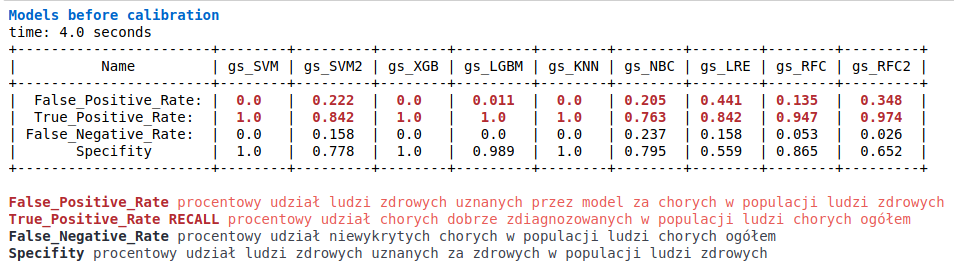

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
from sklearn.ensemble import BaggingClassifier
from simple_colors import * 
from prettytable import PrettyTable

warnings.filterwarnings("ignore")

%matplotlib inline

df= pd.read_csv('/home/wojciech/Pulpit/1/Stroke_Prediction.csv')
print(df.shape)
print()
print(df.columns)
df.head(3)

(43400, 12)

Index(['ID', 'Gender', 'Age_In_Days', 'Hypertension', 'Heart_Disease',
       'Ever_Married', 'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI',
       'Smoking_Status', 'Stroke'],
      dtype='object')


,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,17412,Female,2928.0,0,0,No,Private,Urban,110.89,17.6,NaN,0


Sample reduction:

In [2]:
df = df.sample(frac = 1.00, random_state=10) 
df.shape

(43400, 12)

#### Start pomiaru czasu

In [3]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())

Fri Jun  5 22:01:12 2020


### Tool for automatic coding of discrete variables 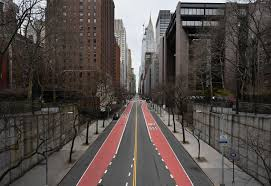


In [4]:
a,b = df.shape     #<- ile mamy kolumn
b

print('DISCRETE FUNCTIONS CODED')
print('------------------------')
for i in range(1,b):
    i = df.columns[i]
    f = df[i].dtypes
    if f == np.object:
        print(i,"---",f)   
    
        if f == np.object:
        
            df[i] = pd.Categorical(df[i]).codes
        
            continue

DISCRETE FUNCTIONS CODED
------------------------
Gender --- object
Ever_Married --- object
Type_Of_Work --- object
Residence --- object
Smoking_Status --- object


In [5]:
df.fillna(7777, inplace=True)

In [6]:
X = df.drop('Stroke', axis=1) 
y = df['Stroke']  

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123,stratify=y)

# <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Oversampling   !! 
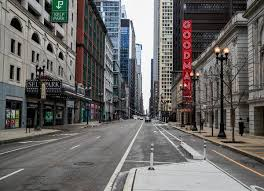

In [7]:
def oversampling(ytrain, Xtrain):
    import matplotlib.pyplot as plt
    
    global Xtrain_OV
    global ytrain_OV

    calss1 = np.round((sum(ytrain == 1)/(sum(ytrain == 0)+sum(ytrain == 1))),decimals=2)*100
    calss0 = np.round((sum(ytrain == 0)/(sum(ytrain == 0)+sum(ytrain == 1))),decimals=2)*100
    
    print("y = 0: ", sum(ytrain == 0),'-------',calss0,'%')
    print("y = 1: ", sum(ytrain == 1),'-------',calss1,'%')
    print('--------------------------------------------------------')
    
    ytrain.value_counts(dropna = False, normalize=True).plot(kind='pie',title='Before oversampling')
    plt.show
    print()
    
    Proporcja = sum(ytrain == 0) / sum(ytrain == 1)
    Proporcja = np.round(Proporcja, decimals=0)
    Proporcja = Proporcja.astype(int)
       
    ytrain_OV = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0) 
    Xtrain_OV = pd.concat([Xtrain.loc[ytrain==1, :]] * Proporcja, axis = 0)
    
    ytrain_OV = pd.concat([ytrain, ytrain_OV], axis = 0).reset_index(drop = True)
    Xtrain_OV = pd.concat([Xtrain, Xtrain_OV], axis = 0).reset_index(drop = True)
    
    Xtrain_OV = pd.DataFrame(Xtrain_OV)
    ytrain_OV = pd.DataFrame(ytrain_OV)
    

    
    print("Before oversampling Xtrain:     ", Xtrain.shape)
    print("Before oversampling ytrain:     ", ytrain.shape)
    print('--------------------------------------------------------')
    print("After oversampling Xtrain_OV:  ", Xtrain_OV.shape)
    print("After oversampling ytrain_OV:  ", ytrain_OV.shape)
    print('--------------------------------------------------------')
    
    
    ax = plt.subplot(1, 2, 1)
    ytrain.value_counts(dropna = False, normalize=True).plot(kind='pie',title='Before oversampling')
    plt.show
    
       
    kot = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0)
    kot = pd.concat([ytrain, kot], axis = 0).reset_index(drop = True)
    ax = plt.subplot(1, 2, 2)
    kot.value_counts(dropna = False, normalize=True).plot(kind='pie',title='After oversampling')
    plt.show

y = 0:  34094 ------- 98.0 %
y = 1:  626 ------- 2.0 %
--------------------------------------------------------

Before oversampling Xtrain:      (34720, 11)
Before oversampling ytrain:      (34720,)
--------------------------------------------------------
After oversampling Xtrain_OV:   (68524, 11)
After oversampling ytrain_OV:   (68524, 1)
--------------------------------------------------------


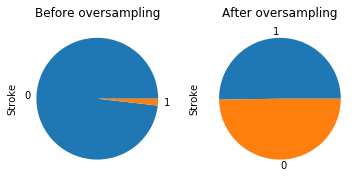

In [8]:
oversampling(y_train, X_train)

I used six models of GaussianNB, LogisticRegression, CatBoostClassifier in their basic version without oversamplin and with oversampling. We will see what differences in the minority set classification the oversampling method gives.!!

I get rid of one dimension from the ytrain_OV set so that the set is similar to y_test.

In [9]:
print(Xtrain_OV.shape)
print(ytrain_OV.shape)
ytrain_OV = ytrain_OV['Stroke']
print(ytrain_OV.shape)

(68524, 11)
(68524, 1)
(68524,)


W poprzednim wpisie uznaliśmy, że oversampling poprawiło jakość klasyfikacji. Kolejne działania będą opierały sie na danych zbilansowanych przez oversampling. Dlatego teraz podmieniamy zwykłą próbę na próbę po oversamoling.

In [10]:
X_train = Xtrain_OV
y_train = ytrain_OV
print(X_train.shape)
print(y_train.shape)

(68524, 11)
(68524,)


## <span style="color:blue">Oversampling dla cross-validation

<span style="color:blue">Teraz robimy oversampling dla wartości testowych. Robimy tak ponieważ bedziemy robić oversampling, gdzie podział na zbiór testowy i treningowy jest robiony wielokrotnie (fałdy). Więc do równania oversampling wstawiamy połaczomy zbiór testowy i wynikowy. A warto żeby oba te zbiory były zbilansowane przez oversampling.  

In [11]:
X = df.drop('Stroke', axis=1) 
y = df['Stroke']  

In [12]:
X.shape

(43400, 11)

y = 0:  42617 ------- 98.0 %
y = 1:  783 ------- 2.0 %
--------------------------------------------------------

Before oversampling Xtrain:      (43400, 11)
Before oversampling ytrain:      (43400,)
--------------------------------------------------------
After oversampling Xtrain_OV:   (85682, 11)
After oversampling ytrain_OV:   (85682, 1)
--------------------------------------------------------


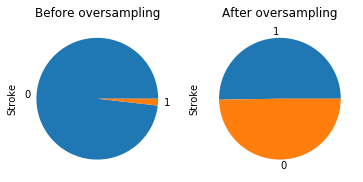

In [13]:
oversampling(y, X)

In [14]:
Data = Xtrain_OV
target = ytrain_OV
print("output:",Data.shape)
print("output:",target.shape)
print('----------')
print("input:", df.shape)

output: (85682, 11)
output: (85682, 1)
----------
input: (43400, 12)


## I create 4 groups of classifiers:
1. Normal classifiers after oversampling,
2. Classifiers after bagging
3. Standard calibrators
4. Classifiers after bagging calibrated

### Below are 2 basic groups: 1. Classifiers after oversampling, 2. Classifiers after bagging

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC 
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
import time

RFC = RandomForestClassifier()

classifiers_A = [RFC]
nameA = ['RFC']

for n,t in zip(nameA,classifiers_A):          ## Szkolenie modeli w pętli
    start_time = time.time()
    t.fit(X_train, y_train)
    p = np.round((time.time() - start_time),decimals=1)
    print(blue(n),p,"---",time.ctime())

### Wzmacnianie przez bagowanie!

RFC_b = BaggingClassifier(base_estimator=RFC, n_estimators=10, max_samples=0.8, max_features=0.8)

classifiers_B = [RFC_b]
nameB = ['RFC_b']
 
print('-------------------------------------')
    
for f,p in zip(nameB,classifiers_B):            ## Szkolenie zbagowanych modeli w pętli
    start_time = time.time()
    p.fit(X_train, y_train)         
    k = np.round((time.time() - start_time),decimals=1)
    print(blue(f),k,"---",time.ctime())


RFC 8.5 --- Fri Jun  5 22:01:21 2020
-------------------------------------
RFC_b 40.6 --- Fri Jun  5 22:02:02 2020


# <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Cross validation
#### <span style="color:blue">Podział na fołdy dla wszystkich modeli:

In [16]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5,            # 5-krotna weryfikacja krzyżowa
                                    n_repeats=3,           # z 3-ema powtórzeniami
                                    random_state=999)

### <span style="color:blue">Zbiór hiperparametrów dla każdego modelu:

In [17]:
params_RFC1 = {
 'max_depth': [2, 3],
 'max_features':['sqrt'],
 'min_samples_leaf': [3, 4],
 'n_estimators':  [500,1000],
 'criterion' :['gini']}

params_RFC2 = {
 'max_depth': [2, 6],
 'max_features':['auto'],
 'min_samples_leaf': [4, 5],
 'n_estimators':  [500,1000],
 'criterion' :['gini']}

params_RFC3 = {
 'max_depth': [4, 5],
 'max_features':['sqrt'],
 'min_samples_leaf': [3, 4],
 'n_estimators':  [800,1400],
 'criterion' :['gini']}

params_RFC4 = {
 'max_depth': [2, 3],
 'max_features':['log2'],
 'min_samples_leaf': [3, 4],
 'n_estimators':  [900,1200],
 'criterion' :['entropy']}

#n_estimators = [100, 300, 500, 800, 1200]
#max_depth = [5, 8, 15, 25, 30]
#max_features': ['auto', 'sqrt', 'log2']
#min_samples_split = [2, 5, 10, 15, 100]
#min_samples_leaf = [1, 2, 5, 10]
#'criterion' :['gini', 'entropy']

params_RFC5 = {
 'max_depth': [2, 3],
 'min_samples_leaf': [3, 4],
 'n_estimators':  [500,1000]}

params_RFC6 = {
 'max_depth': [2, 3],
 'min_samples_leaf': [3, 4],
 'n_estimators':  [500,1000],
 'criterion' :['gini']}

params_RFC7 = {
 'max_depth': [2, 3],
 'min_samples_leaf': [3, 4],
 'n_estimators':  [500,1000],
 'criterion' :['entropy']}
        
params_RFC8 = {
 'max_depth': [2, 3],
 'min_samples_leaf': [3, 4],
 'n_estimators': [500,1200]}

params_RFC9 = {
 'max_depth': [2, 3],
 'max_features': ['sqrt'],
 'min_samples_leaf': [3, 4],
 'n_estimators':  [500,1000]}


params_RFC10 = {
 'max_depth': [2, 3],
 'max_features': ['sqrt'],
 'min_samples_leaf': [3, 4],
 'n_estimators':  [500,1000]}

params_RFC11 = {
 'max_depth': [2, 3],
 'max_features': ['sqrt'],
 'min_samples_leaf': [2, 3],
 'n_estimators':  [500,800]}

params_RFC12 = {
 'max_depth': [2, 3],
 'max_features': ['log2'],
 'min_samples_leaf': [3, 4],
 'n_estimators':  [800,1200]}

## Szkolenie modeli na zbiorze treningowym

In [18]:
from sklearn.model_selection import GridSearchCV


##==============================================================================

RFC1 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC1,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

RFC2 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC2,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 
##==============================================================================

RFC3 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC3,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 
##==============================================================================

RFC4 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC4,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

RFC5 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC5,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 
##==============================================================================

RFC6 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC6,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

RFC7 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC7,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 
##==============================================================================

RFC8 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC8,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

RFC9 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC9,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

RFC10 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC10,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

RFC11 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC11,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

RFC12 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC12,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 


# Szkolenie modeli na zbiorze X_train, y_train
### <span style="color:blue">Exercise model using the full range of balanced data (after oversample):

In [19]:
classifiers_F = [RFC1,RFC2,RFC3,RFC4,RFC5,RFC6,RFC7,RFC8,RFC9]
nameF = ['RFC1','RFC2','RFC3','RFC4','RFC5','RFC6','RFC7','RFC8','RFC9']

In [20]:
from sklearn.model_selection import GridSearchCV
import joblib

for n,t in zip(nameF,classifiers_F):          ## Szkolenie modeli w pętli
    t.fit(Data, target)
    filename ='/home/wojciech/Pulpit/7/cząstkowy_{0}.pkl'.format(n)  #<= zapisujemy model na dysku
    _ = joblib.dump(t, filename, compress=9)
    p = np.round((time.time() - start_time),decimals=1)
    print(blue(n),p,"---",time.ctime())

Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 39.5min finished


RFC1 2438.9 --- Fri Jun  5 22:42:00 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 52.7min finished


RFC2 5670.1 --- Fri Jun  5 23:35:52 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 84.2min finished


RFC3 10770.6 --- Sat Jun  6 01:00:52 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 63.2min finished


RFC4 14607.0 --- Sat Jun  6 02:04:48 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 39.3min finished


RFC5 17008.7 --- Sat Jun  6 02:44:50 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 39.6min finished


RFC6 19409.5 --- Sat Jun  6 03:24:51 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 44.8min finished


RFC7 22148.3 --- Sat Jun  6 04:10:30 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 44.2min finished


RFC8 24854.3 --- Sat Jun  6 04:55:36 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 39.0min finished


RFC9 27237.6 --- Sat Jun  6 05:35:19 2020


## <span style="color:red"> Szkolenie modeli na pełnym zbiorze

In [21]:
from sklearn.model_selection import GridSearchCV


##==============================================================================

p_RFC1 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC1,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

p_RFC2 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC2,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 
##==============================================================================

p_RFC3 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC3,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 
##==============================================================================

p_RFC4 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC4,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

p_RFC5 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC5,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 
##==============================================================================

p_RFC6 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC6,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

p_RFC7 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC7,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 
##==============================================================================

p_RFC8 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC8,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

p_RFC9 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC9,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

p_RFC10 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC10,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

p_RFC11 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC11,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 

##==============================================================================

p_RFC12 = GridSearchCV(estimator=RFC,
                      param_grid = params_RFC12,
                      cv=cv_method,
                      verbose=1,
                      scoring = 'roc_auc') 


# Szkolenie pełny zakres

In [22]:
classifiers_P = [p_RFC1,p_RFC2,p_RFC3,p_RFC4,p_RFC5,p_RFC6,p_RFC7,p_RFC8,p_RFC9]
nameP = ['p_RFC1','p_RFC2','p_RFC3','p_RFC4','p_RFC5','p_RFC6','p_RFC7','p_RFC8','p_RFC9']

In [23]:
from sklearn.model_selection import GridSearchCV
import joblib

for n,t in zip(nameP,classifiers_P):          ## Szkolenie modeli w pętli
    t.fit(Data, target)
    filename ='/home/wojciech/Pulpit/7/pełny_{0}.pkl'.format(n)  #<= zapisujemy model na dysku
    _ = joblib.dump(t, filename, compress=9)
    p = np.round((time.time() - start_time),decimals=1)
    print(blue(n),p,"---",time.ctime())

Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 38.9min finished


p_RFC1 29616.9 --- Sat Jun  6 06:14:58 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 53.0min finished


p_RFC2 32862.9 --- Sat Jun  6 07:09:04 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 82.4min finished


p_RFC3 37887.4 --- Sat Jun  6 08:32:49 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 61.4min finished


p_RFC4 41628.7 --- Sat Jun  6 09:35:10 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 38.1min finished


p_RFC5 43959.4 --- Sat Jun  6 10:14:01 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 38.1min finished


p_RFC6 46291.0 --- Sat Jun  6 10:52:52 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 44.1min finished


p_RFC7 48965.8 --- Sat Jun  6 11:37:27 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 43.2min finished


p_RFC8 51608.9 --- Sat Jun  6 12:21:30 2020
Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 38.2min finished


p_RFC9 53929.5 --- Sat Jun  6 13:00:11 2020


##  <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3"> Zdefiniowane zespoły klasyfikatorów

    classifiers_F - szkolone na zbiorze X_train, y_train
    classifiers_P - szkolone na pełnym zbiorze Data, target

### <span style="color:blue">Sprawdzenie najlepszego zestawu hiperparametrów:

In [25]:
print('Best params RFC1:', RFC1.best_params_)
print('Best params RFC2:', RFC2.best_params_)
print('Best params RFC3:', RFC3.best_params_)
print('Best params RFC4:', RFC4.best_params_)
print('Best params RFC5:', RFC5.best_params_)
print('Best params RFC6:', RFC6.best_params_)
print('Best params RFC7:', RFC7.best_params_)
print('Best params RFC8:', RFC8.best_params_)
print('Best params RFC9:', RFC9.best_params_)

Best params RFC1: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 500}
Best params RFC2: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 1000}
Best params RFC3: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 800}
Best params RFC4: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 900}
Best params RFC5: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 1000}
Best params RFC6: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 500}
Best params RFC7: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 1000}
Best params RFC8: {'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 1200}
Best params RFC9: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}


In [26]:
print('Best params p_RFC1:', p_RFC1.best_params_)
print('Best params p_RFC2:', p_RFC2.best_params_)
print('Best params p_RFC3:', p_RFC3.best_params_)
print('Best params p_RFC4:', p_RFC4.best_params_)
print('Best params p_RFC5:', p_RFC5.best_params_)
print('Best params p_RFC6:', p_RFC6.best_params_)
print('Best params p_RFC7:', p_RFC7.best_params_)
print('Best params p_RFC8:', p_RFC8.best_params_)
print('Best params p_RFC9:', p_RFC9.best_params_)

Best params p_RFC1: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
Best params p_RFC2: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 1000}
Best params p_RFC3: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 1400}
Best params p_RFC4: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 1200}
Best params p_RFC5: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 1000}
Best params p_RFC6: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 1000}
Best params p_RFC7: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 500}
Best params p_RFC8: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 1200}
Best params p_RFC9: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 500}


## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3"> Najważnieszy dla mnie zbiór wskaźników Type_error

#### <span style="color:blue">False_Positive_Rate 
    - procentowy udział ludzi zdrowych uznanych przez model za chorych w populacji ludzi zdrowych

#### <span style="color:blue">True_Positive_Rate RECALL 
    - wskaźnik ten pokazuje jaka jest wykrywalność choroby przez model.

In [27]:
def Type_error(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):

    
    from sklearn.datasets import make_classification
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from sklearn.metrics import confusion_matrix
    
    from sklearn import metrics
    import simple_colors
    import time   
    
    start_time = time.time()
    
    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)    
    
    FPR = ['False_Positive_Rate:']
    TPR = ['True_Positive_Rate: ']
    FNR = ['False_Negative_Rate: ']
    SPEC = ['Specifity']
    
    CAL_FPR = ['CAL_False_Positive_Rate:']
    CAL_TPR = ['CAL_True_Positive_Rate: ']
    CAL_FNR = ['CAL_False_Negative_Rate: ']
    CAL_SPEC = ['CAL_Specifity']

    def compute_metric(model):
        
        
        #model = model.fit(X_train,y_train)   #<-- model już przećwiczył się na pełnych danych
        cm = confusion_matrix(y_test, model.predict(X_test))
        tn, fp, fn, tp = cm.ravel()
        # print('tn: ',tn)
        # print('fp: ',fp)
        # print('fn: ',fn)
        # print('tp: ',tp)
        # print('------------------')
        # print(cm) 
        

        FPR = np.round(fp/(fp + tn),decimals=3)
        TPR = np.round(tp/(tp + fn),decimals=3)
        FNR = np.round(fn/(tp + fn),decimals=3)
        SPEC = np.round(tn/(tn + fp),decimals=3)

        return FPR,TPR,FNR,SPEC

    for cls in six_classifiers:      
        
        results = compute_metric(cls)
        FPR.append(red(results[0],'bold'))
        TPR.append(red(results[1],'bold'))
        FNR.append(results[2])
        SPEC.append(results[3])

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(FPR)
    t.add_row(TPR)
    t.add_row(FNR)
    t.add_row(SPEC)

    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
  ## --------------------------------------------------  
    
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))
  
        start_time = time.time()
    
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
        
            ck = confusion_matrix(y_test, calibrated.predict(X_test))
            tn_c, fp_c, fn_c, tp_c = ck.ravel()
            # print('tn: ',tn)
            # print('fp: ',fp)
            # print('fn: ',fn)
            # print('tp: ',tp)
            # print('------------------')
            # print(cm) 
        

            CAL_FPR = np.round(fp_c/(fp_c + tn_c),decimals=3)
            CAL_TPR = np.round(tp_c/(tp_c + fn_c),decimals=3)
            CAL_FNR = np.round(fn_c/(tp_c + fn_c),decimals=3)
            CAL_SPEC = np.round(tn_c/(tn_c + fp_c),decimals=3)

            return CAL_FPR, CAL_TPR, CAL_FNR, CAL_SPEC

        for cls in six_classifiers:      
        
            results = calibration(cls)
            CAL_FPR.append(red(results[0],'bold'))
            CAL_TPR.append(red(results[1],'bold'))
            CAL_FNR.append(results[2])
            CAL_SPEC.append(results[3])

        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_FPR)
        k.add_row(CAL_TPR)
        k.add_row(CAL_FNR)
        k.add_row(CAL_SPEC)
    
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)
        print(k)
    
    
    print(red('False_Positive_Rate','bold'),red('procentowy udział ludzi zdrowych uznanych przez model za chorych w populacji ludzi zdrowych','italic'))
    print(red('True_Positive_Rate RECALL','bold'), red('procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi chorych ogółem','italic'))
    print(black('False_Negative_Rate','bold'), black('procentowy udział niewykrytych chorych w populacji ludzi chorych ogółem','italic'))
    print(black('Specifity','bold'), black('procentowy udział ludzi zdrowych uznanych za zdrowych w populacji ludzi zdrowych','italic'))

In [28]:
Type_error(classifiers_P,nameP,Data, target,X_test,y_test,calibration=False)

Models before calibration
time: 6.0 seconds
+-----------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|          Name         | p_RFC1 | p_RFC2 | p_RFC3 | p_RFC4 | p_RFC5 | p_RFC6 | p_RFC7 | p_RFC8 | p_RFC9 |
+-----------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  False_Positive_Rate: | 0.307  | 0.259  | 0.296  | 0.313  | 0.308  | 0.308  | 0.311  | 0.308  | 0.307  |
|  True_Positive_Rate:  | 0.854  | 0.879  | 0.885  | 0.866  |  0.86  |  0.86  | 0.866  | 0.866  | 0.866  |
| False_Negative_Rate:  | 0.146  | 0.121  | 0.115  | 0.134  |  0.14  |  0.14  | 0.134  | 0.134  | 0.134  |
|       Specifity       | 0.693  | 0.741  | 0.704  | 0.687  | 0.692  | 0.692  | 0.689  | 0.692  | 0.693  |
+-----------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+

False_Positive_Rate procentowy udział ludzi zdrowych uznanych przez model za chorych w populacji lu

In [29]:
Type_error(classifiers_F,nameF,X_train, y_train,X_test,y_test,calibration=False)

Models before calibration
time: 5.0 seconds
+-----------------------+-------+-------+-------+-------+-------+-------+------+-------+-------+
|          Name         |  RFC1 |  RFC2 |  RFC3 |  RFC4 |  RFC5 |  RFC6 | RFC7 |  RFC8 |  RFC9 |
+-----------------------+-------+-------+-------+-------+-------+-------+------+-------+-------+
|  False_Positive_Rate: | 0.307 |  0.26 | 0.298 | 0.312 | 0.307 | 0.307 | 0.31 | 0.307 | 0.307 |
|  True_Positive_Rate:  | 0.854 | 0.885 | 0.885 | 0.866 | 0.866 | 0.854 | 0.86 | 0.866 |  0.86 |
| False_Negative_Rate:  | 0.146 | 0.115 | 0.115 | 0.134 | 0.134 | 0.146 | 0.14 | 0.134 |  0.14 |
|       Specifity       | 0.693 |  0.74 | 0.702 | 0.688 | 0.693 | 0.693 | 0.69 | 0.693 | 0.693 |
+-----------------------+-------+-------+-------+-------+-------+-------+------+-------+-------+

False_Positive_Rate procentowy udział ludzi zdrowych uznanych przez model za chorych w populacji ludzi zdrowych
True_Positive_Rate RECALL procentowy udział chorych dobrze zdiagnoz

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Confusion matrix

In [32]:
def confusion_matrix(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 20 
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve 
    from sklearn.metrics import plot_confusion_matrix
    
    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train) 
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
    target_names = ['0','1']


    for t,cls, ax in zip(name, six_classifiers, axes.flatten()):
        plot_confusion_matrix(cls, 
                              X_test, 
                              y_test, 
                              ax=ax, 
                              cmap='Blues',
                             display_labels=target_names,values_format='')
        ax.title.set_text(type(cls).__name__)
        ax.title.set_color('blue')
        ax.text(-0.5, -0.56, t,fontsize=12)
        ax.text(-0.5, 1.40, 'before calibration',color='black', fontsize=10) 
        
    plt.tight_layout()  
    plt.show()
    
### ---------------------------------------------------
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))

    ### ---------------------------------------------------
    
    
        for cls in six_classifiers:
            calibrated = CalibratedClassifierCV(cls, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
    
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
        target_names = ['0','1']


        for t,cls, ax in zip(name, six_classifiers, axes.flatten()):
            plot_confusion_matrix(cls, 
                                  X_test, 
                                  y_test, 
                                  ax=ax, 
                                  cmap='Blues',
                                 display_labels=target_names,values_format='')
            ax.title.set_text(type(cls).__name__)
            ax.title.set_color('blue')
            ax.text(-0.5, -0.56, t,fontsize=12)
            ax.text(-0.5, 1.40, 'after calibration',color='red', fontsize=10)    ## podtytuł     


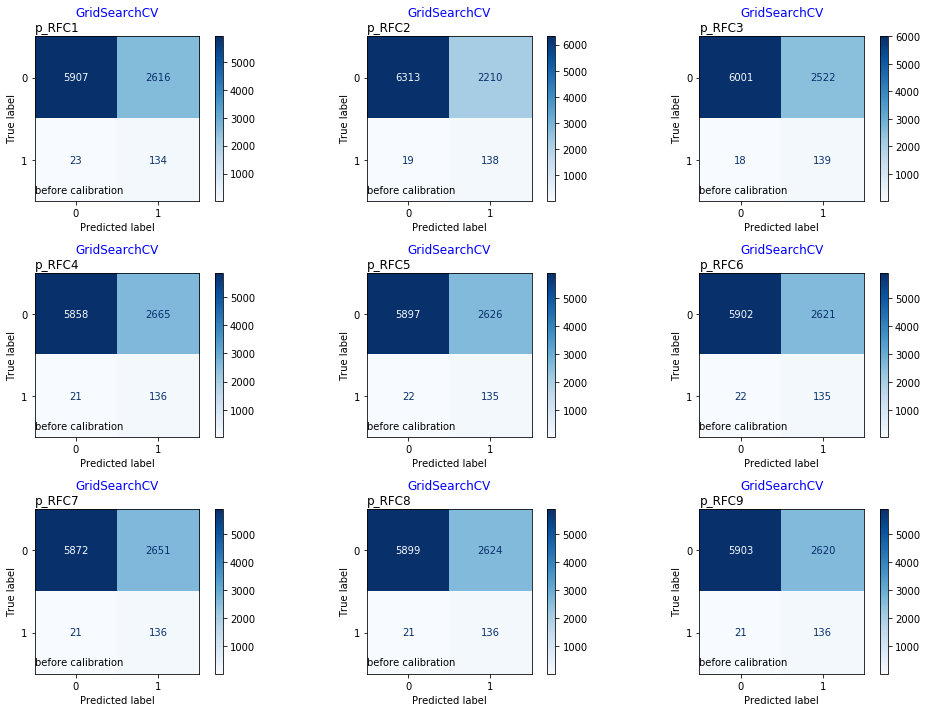

In [33]:
confusion_matrix(classifiers_P,nameP,Data, target,X_test,y_test,calibration=False)

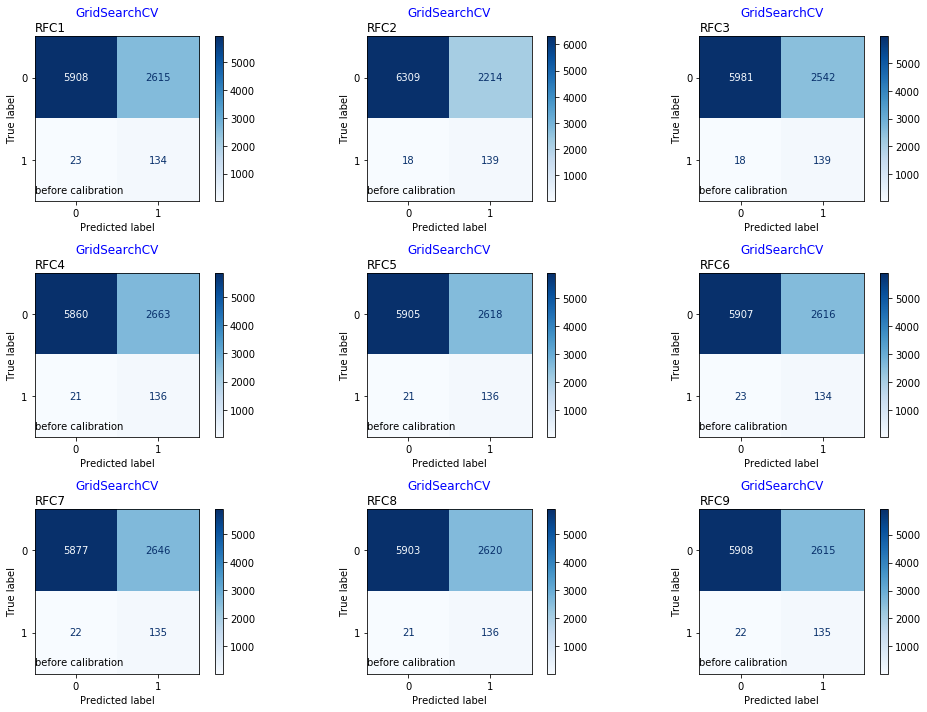

In [34]:
confusion_matrix(classifiers_F,nameF,X_train, y_train,X_test,y_test,calibration=False)

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Recall - Precision!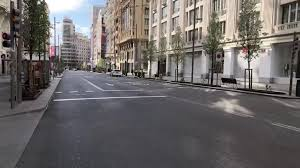

In [35]:
def Recall_Precision(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):

    from sklearn.datasets import make_classification
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve  
    
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
    from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report
    from sklearn.metrics import accuracy_score
    from mlxtend.plotting import plot_learning_curves
    from prettytable import PrettyTable
    import time   
    
    start_time = time.time()
    
    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)
      
    
    Recall_Training = ['Recall Training: ']
    Precision_Training = ['Precision Training: ']
    Recall_Test= ['Recall Test: ']
    Precision_Test = ['Precision Test: ']
    
    CAL_Recall_Training = ['CAL_Recall Training: ']
    CAL_Precision_Training = ['CAL_Precision Training: ']
    CAL_Recall_Test= ['CAL_Recall Test: ']
    CAL_Precision_Test = ['CAL_Precision Test: ']   

    def compute_metric2(model):

        Recall_Training = np.round(recall_score(y_train, model.predict(X_train)), decimals=3)
        Precision_Training = np.round(precision_score(y_train, model.predict(X_train)), decimals=3)
        Recall_Test = np.round(recall_score(y_test, model.predict(X_test)), decimals=3) 
        Precision_Test = np.round(precision_score(y_test, model.predict(X_test)), decimals=3)
        
        return Recall_Training, Precision_Training, Recall_Test, Precision_Test
    
    for cls in six_classifiers:

        results = compute_metric2(cls)
        Recall_Training.append(results[0])
        Precision_Training.append(results[1])
        Recall_Test.append(blue(results[2],'bold'))
        Precision_Test.append((blue(results[3],'bold')))
   
    
    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(Recall_Training)
    t.add_row(Precision_Training)
    t.add_row(Recall_Test)
    t.add_row(Precision_Test)

    
    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
    
  ### ---------------------------------------------------------  
    
    
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))

            
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
       
            
        
            CAL_Recall_Training = np.round(recall_score(y_train, calibrated.predict(X_train)), decimals=3)
            CAL_Precision_Training = np.round(precision_score(y_train, calibrated.predict(X_train)), decimals=3)
            CAL_Recall_Test = np.round(recall_score(y_test, calibrated.predict(X_test)), decimals=3) 
            CAL_Precision_Test = np.round(precision_score(y_test, calibrated.predict(X_test)), decimals=3)
        
            return CAL_Recall_Training, CAL_Precision_Training, CAL_Recall_Test, CAL_Precision_Test 
    
        start_time = time.time()
    
        for cls in six_classifiers:

            results = calibration(cls)
            CAL_Recall_Training.append(results[0])
            CAL_Precision_Training.append(results[1])
            CAL_Recall_Test.append(blue(results[2],'bold'))
            CAL_Precision_Test.append((blue(results[3],'bold')))
   
        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_Recall_Training)
        k.add_row(CAL_Precision_Training)
        k.add_row(CAL_Recall_Test)
        k.add_row(CAL_Precision_Test)   
    
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)
        print(k)
    print(blue('Wskaźniki pokazują RECALL i PRECISION dla klasy 1','bold'))
    print(blue('RECALL', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych wśród wszystkich ludzi chorych','italic'))
    print(blue('PRECISION', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi zdiagnozowanych fałszywie (zdrowych uznanych przez model za chorych) i dobrze zdiagnozowanych (chorych uznanych przez model za chorych)','italic'))

In [36]:
Recall_Precision(classifiers_P,nameP,Data, target,X_test,y_test,calibration=False)

Models before calibration
time: 115.0 seconds
+----------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|         Name         | p_RFC1 | p_RFC2 | p_RFC3 | p_RFC4 | p_RFC5 | p_RFC6 | p_RFC7 | p_RFC8 | p_RFC9 |
+----------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  Recall Training:    | 0.872  | 0.891  | 0.893  | 0.883  | 0.874  | 0.872  | 0.883  | 0.876  | 0.876  |
| Precision Training:  | 0.738  | 0.774  |  0.75  | 0.737  | 0.737  | 0.737  | 0.738  | 0.738  | 0.738  |
|    Recall Test:      | 0.854  | 0.879  | 0.885  | 0.866  |  0.86  |  0.86  | 0.866  | 0.866  | 0.866  |
|   Precision Test:    | 0.049  | 0.059  | 0.052  | 0.049  | 0.049  | 0.049  | 0.049  | 0.049  | 0.049  |
+----------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+

Wskaźniki pokazują RECALL i PRECISION dla klasy 1
RECALL procentowy udział chorych dobrze zdiagnozowanych

In [37]:
Recall_Precision(classifiers_F,nameF,X_train, y_train,X_test,y_test,calibration=False)

Models before calibration
time: 82.0 seconds
+----------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|         Name         |  RFC1 |  RFC2 |  RFC3 |  RFC4 |  RFC5 |  RFC6 |  RFC7 |  RFC8 |  RFC9 |
+----------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|  Recall Training:    | 0.875 | 0.895 | 0.893 |  0.89 | 0.877 | 0.879 | 0.888 | 0.879 | 0.877 |
| Precision Training:  | 0.737 | 0.773 | 0.747 | 0.737 | 0.737 | 0.737 | 0.738 | 0.737 | 0.737 |
|    Recall Test:      | 0.854 | 0.885 | 0.885 | 0.866 | 0.866 | 0.854 |  0.86 | 0.866 |  0.86 |
|   Precision Test:    | 0.049 | 0.059 | 0.052 | 0.049 | 0.049 | 0.049 | 0.049 | 0.049 | 0.049 |
+----------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+

Wskaźniki pokazują RECALL i PRECISION dla klasy 1
RECALL procentowy udział chorych dobrze zdiagnozowanych wśród wszystkich ludzi chorych
PRECISION procentowy udział chorych dobrz

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Classification score

In [38]:
def classification_score(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):

    from sklearn.datasets import make_classification
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve   
    from sklearn.metrics import precision_recall_fscore_support as score
    import time   
    
    start_time = time.time()

    Precision_0 = ['Precision_0: ']
    Precision_1 = ['Precision_1: ']
    Recall_0 = ['Recall_0: ']
    Recall_1 = ['Recall_1: ']
    f1_score_0 = ['f1-score_0: ']
    f1_score_1 = ['f1-score_1: ']
    Support_0 = ['Support_0: ']
    Support_1 = ['Support_1: ']
    
    
    CAL_Precision_0 = ['CAL_Precision_0: ']
    CAL_Precision_1 = ['CAL_Precision_1: ']
    CAL_Recall_0 = ['CAL_Recall_0: ']
    CAL_Recall_1 = ['CAL_Recall_1: ']
    CAL_f1_score_0 = ['CAL_f1-score_0: ']
    CAL_f1_score_1 = ['CAL_f1-score_1: ']
    CAL_Support_0 = ['CAL_Support_0: ']
    CAL_Support_1 = ['CAL_Support_1: ']

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)
        
    
    def compute_metric4(model):

        precision, recall, fscore, support = score(y_test, model.predict(X_test))
    
        Precision_0 = np.round(precision[:1],decimals=3).item()
        Precision_1 = np.round(precision[1:],decimals=3).item()
        Recall_0 = np.round(recall[:1],decimals=3).item()
        Recall_1 = np.round(recall[1:],decimals=3).item()
        f1_score_0 = np.round(fscore[:1],decimals=3).item()
        f1_score_1 = np.round(fscore[1:],decimals=3).item()
        Support_0 = np.round(support[:1],decimals=3).item()
        Support_1 = np.round(support[1:],decimals=3).item()
        
        return Precision_0, Precision_1, Recall_0, Recall_1, f1_score_0, f1_score_1, Support_0, Support_1

    for cls in six_classifiers:

        results = compute_metric4(cls)
        Precision_0.append(results[0])
        Precision_1.append(blue(results[1],'bold'))
        Recall_0.append(results[2])
        Recall_1.append(blue(results[3],'bold'))
        f1_score_0.append(results[4])
        f1_score_1.append(blue(results[5],'bold'))
        Support_0.append(results[6])
        Support_1.append(blue(results[7],'bold'))
         

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(Precision_0)
    t.add_row(Precision_1)
    t.add_row(Recall_0)
    t.add_row(Recall_1)
    t.add_row(f1_score_0)
    t.add_row(f1_score_1)
    t.add_row(Support_0)
    t.add_row(Support_1)


    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
    
   ## ------------------------------------------

    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))
  
        start_time = time.time()
    
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
            precision, recall, fscore, support = score(y_test, calibrated.predict(X_test))
                
            CAL_Precision_0 = np.round(precision[:1],decimals=3).item()
            CAL_Precision_1 = np.round(precision[1:],decimals=3).item()
            CAL_Recall_0 = np.round(recall[:1],decimals=3).item()
            CAL_Recall_1 = np.round(recall[1:],decimals=3).item()
            CAL_f1_score_0 = np.round(fscore[:1],decimals=3).item()
            CAL_f1_score_1 = np.round(fscore[1:],decimals=3).item()
            CAL_Support_0 = np.round(support[:1],decimals=3).item()
            CAL_Support_1 = np.round(support[1:],decimals=3).item()
        
            return CAL_Precision_0, CAL_Precision_1, CAL_Recall_0, CAL_Recall_1, CAL_f1_score_0, CAL_f1_score_1, CAL_Support_0, CAL_Support_1
    
        for cls in six_classifiers:

            results = calibration(cls)
            CAL_Precision_0.append(results[0])
            CAL_Precision_1.append(blue(results[1],'bold'))
            CAL_Recall_0.append(results[2])
            CAL_Recall_1.append(blue(results[3],'bold'))
            CAL_f1_score_0.append(results[4])
            CAL_f1_score_1.append(blue(results[5],'bold'))
            CAL_Support_0.append(results[6])
            CAL_Support_1.append(blue(results[7],'bold'))
   
        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_Precision_0)
        k.add_row(CAL_Precision_1)
        k.add_row(CAL_Recall_0)
        k.add_row(CAL_Recall_1)
        k.add_row(CAL_f1_score_0)
        k.add_row(CAL_f1_score_1)
        k.add_row(CAL_Support_0)
        k.add_row(CAL_Support_1)
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)
        print(k)
    print(blue('RECALL', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych wśród wszystkich ludzi chorych','italic'))
    print(blue('PRECISION', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi zdiagnozowanych fałszywie (zdrowych uznanych przez model za chorych) i dobrze zdiagnozowanych (chorych uznanych przez model za chorych)','italic')) 
    

In [39]:
classification_score(classifiers_P,nameP,Data, target,X_test,y_test,calibration=False)

Models before calibration
time: 6.0 seconds
+---------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|      Name     | p_RFC1 | p_RFC2 | p_RFC3 | p_RFC4 | p_RFC5 | p_RFC6 | p_RFC7 | p_RFC8 | p_RFC9 |
+---------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| Precision_0:  | 0.996  | 0.997  | 0.997  | 0.996  | 0.996  | 0.996  | 0.996  | 0.996  | 0.996  |
| Precision_1:  | 0.049  | 0.059  | 0.052  | 0.049  | 0.049  | 0.049  | 0.049  | 0.049  | 0.049  |
|   Recall_0:   | 0.693  | 0.741  | 0.704  | 0.687  | 0.692  | 0.692  | 0.689  | 0.692  | 0.693  |
|   Recall_1:   | 0.854  | 0.879  | 0.885  | 0.866  |  0.86  |  0.86  | 0.866  | 0.866  | 0.866  |
|  f1-score_0:  | 0.817  |  0.85  | 0.825  | 0.813  | 0.817  | 0.817  | 0.815  | 0.817  | 0.817  |
|  f1-score_1:  | 0.092  |  0.11  | 0.099  | 0.092  | 0.093  | 0.093  | 0.092  | 0.093  | 0.093  |
|  Support_0:   |  8523  |  8523  |  8523  |  8523  |  8523  |  8

In [40]:
classification_score(classifiers_F,nameF,X_train, y_train,X_test,y_test,calibration=False)

Models before calibration
time: 5.0 seconds
+---------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Name     |  RFC1 |  RFC2 |  RFC3 |  RFC4 |  RFC5 |  RFC6 |  RFC7 |  RFC8 |  RFC9 |
+---------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Precision_0:  | 0.996 | 0.997 | 0.997 | 0.996 | 0.996 | 0.996 | 0.996 | 0.996 | 0.996 |
| Precision_1:  | 0.049 | 0.059 | 0.052 | 0.049 | 0.049 | 0.049 | 0.049 | 0.049 | 0.049 |
|   Recall_0:   | 0.693 |  0.74 | 0.702 | 0.688 | 0.693 | 0.693 |  0.69 | 0.693 | 0.693 |
|   Recall_1:   | 0.854 | 0.885 | 0.885 | 0.866 | 0.866 | 0.854 |  0.86 | 0.866 |  0.86 |
|  f1-score_0:  | 0.817 |  0.85 | 0.824 | 0.814 | 0.817 | 0.817 | 0.815 | 0.817 | 0.818 |
|  f1-score_1:  | 0.092 | 0.111 | 0.098 | 0.092 | 0.093 | 0.092 | 0.092 | 0.093 | 0.093 |
|  Support_0:   |  8523 |  8523 |  8523 |  8523 |  8523 |  8523 |  8523 |  8523 |  8523 |
|  Support_1:   |  157  |  157  |  157  |  157  |  157  

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">AUC score

In [41]:
def AUC_score(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from sklearn import metrics
    import time   
    
    start_time = time.time()

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)    
    
    AUC_train = ['AUC_train: ']
    AUC_test = ['AUC_test: ']
    CAL_AUC_train = ['AUC_train: ']
    CAL_AUC_test = ['AUC_test: ']
    
    
    def compute_metric(model):

        auc_train = np.round(metrics.roc_auc_score(y_train,model.predict_proba(X_train)[:,1]),decimals=3)
        auc_test = np.round(metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:,1]),decimals=3)

        return auc_train, auc_test

    for cls in six_classifiers:

        results = compute_metric(cls)
        AUC_train.append(results[0])
        AUC_test.append(blue(results[1],'bold'))


    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(AUC_train)
    t.add_row(AUC_test)
    
    
    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s secondS' % g)
    print(t)
    
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))
    
        start_time = time.time()
    
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
         
            CAL_AUC_train = np.round(metrics.roc_auc_score(y_train,calibrated.predict_proba(X_train)[:,1]),decimals=3)
            CAL_AUC_test = np.round(metrics.roc_auc_score(y_test,calibrated.predict_proba(X_test)[:,1]),decimals=3)

            return CAL_AUC_train, CAL_AUC_test

    
        for cls in six_classifiers:

            results = calibration(cls)
            CAL_AUC_train.append(results[0])
            CAL_AUC_test.append(blue(results[1],'bold'))
       
   
        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_AUC_train)
        k.add_row(CAL_AUC_test)
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)    
        print(k)
    

In [42]:
AUC_score(classifiers_P,nameP,Data, target,X_test,y_test,calibration=False)

Models before calibration
time: 58.0 secondS
+-------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|     Name    | p_RFC1 | p_RFC2 | p_RFC3 | p_RFC4 | p_RFC5 | p_RFC6 | p_RFC7 | p_RFC8 | p_RFC9 |
+-------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| AUC_train:  | 0.862  | 0.897  | 0.883  | 0.862  | 0.862  | 0.862  | 0.863  | 0.862  | 0.862  |
|  AUC_test:  | 0.855  | 0.893  | 0.878  | 0.857  | 0.855  | 0.855  | 0.856  | 0.855  | 0.854  |
+-------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+



In [43]:
AUC_score(classifiers_F,nameF,X_train, y_train,X_test,y_test,calibration=False)

Models before calibration
time: 41.0 secondS
+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|     Name    |  RFC1 |  RFC2 |  RFC3 |  RFC4 |  RFC5 |  RFC6 |  RFC7 |  RFC8 |  RFC9 |
+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| AUC_train:  | 0.864 | 0.898 | 0.885 | 0.864 | 0.864 | 0.864 | 0.863 | 0.864 | 0.864 |
|  AUC_test:  | 0.855 | 0.892 | 0.878 | 0.857 | 0.855 | 0.855 | 0.856 | 0.855 | 0.855 |
+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+



## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Binary Classficators Plots  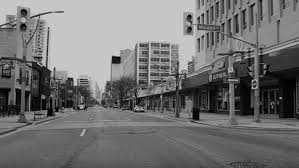

In [44]:
def BinaryClassPlot(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    import time
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20 
    
    start_time = time.time()
    
    from plot_metric.functions import BinaryClassification

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train) 
       
    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)
        
    for i in range(9):
        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')
            
        model = six_classifiers[i]
        bc = BinaryClassification(y_test, model.predict_proba(X_test)[:,1], labels=["Class 1", "Class 2"])
        bc.plot_roc_curve(title=type(six_classifiers[i]).__name__)
        ax.text(0.0, 1.09, 'before calibration',color='black', fontsize=10) 
        ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł

 ### ------------------------------------------------------------------------------       
    if calibration != True:
        print()
    else:    
           
        #for cls in six_classifiers:
        #    cls.fit(X_train, y_train)
                            
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

        for i in range(9):
            col, row = i%3,i//3
            ax = plt.subplot(grid[row,col]) 
            ax.title.set_color('blue')
            
            model = six_classifiers[i]
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)        
                
            bc = BinaryClassification(y_test, calibrated.predict_proba(X_test)[:,1], labels=["Class 1", "Class 2"])
            bc.plot_roc_curve(title=type(six_classifiers[i]).__name__)
            ax.text(0.0, 1.09, 'after calibration',color='red', fontsize=10)    ## podtytuł     
            ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł   
        
        
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)    

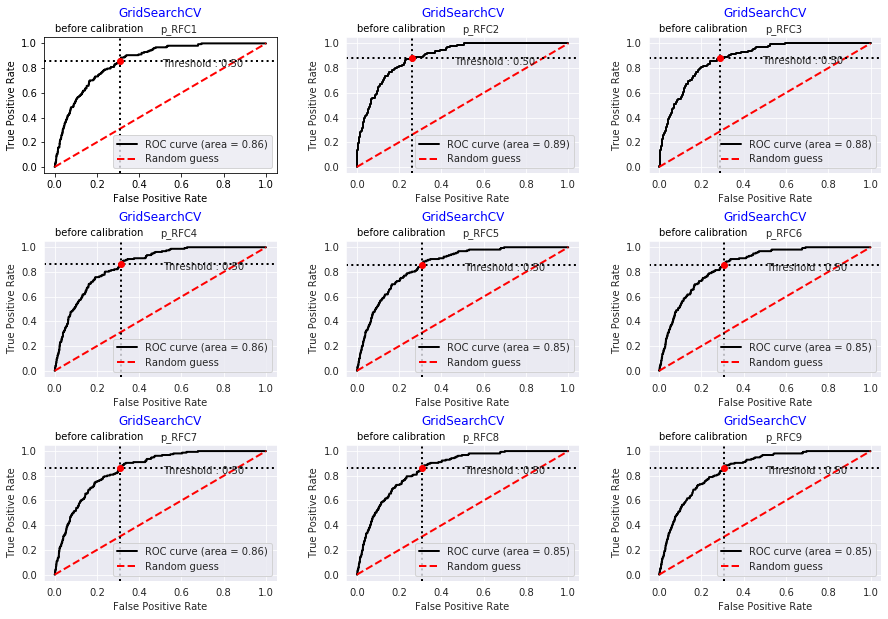

In [45]:
BinaryClassPlot(classifiers_P,nameP,Data, target,X_test,y_test,calibration=False)

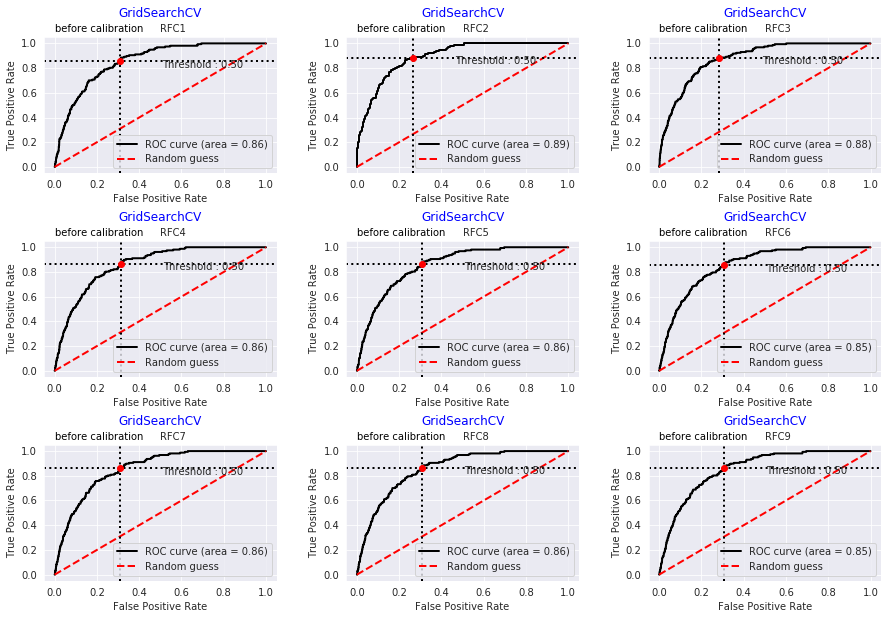

In [46]:
BinaryClassPlot(classifiers_F,nameF,X_train, y_train,X_test,y_test,calibration=False)

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3"> ROC AUC plots

In [47]:
def plot_roc(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    import time
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20 
    
    import scikitplot as skplt
    
    start_time = time.time()
    
    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)

    for i in range(9):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = six_classifiers[i]
        skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), ax=ax, title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł
        ax.text(0.0, 1.09, 'before calibration',color='black', fontsize=10)
## ---------------------------------------------------------------------------------------------------
    
    if calibration != True:
        print()
    else:    
    
    
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)
    
    
        #for cls in six_classifiers:
        #    cls.fit(X_train, y_train)

        for i in range(9):

            col, row = i%3,i//3
            ax = plt.subplot(grid[row,col]) 
            ax.title.set_color('blue')

            model = six_classifiers[i]
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)        
        
            skplt.metrics.plot_roc(y_test, calibrated.predict_proba(X_test), ax=ax, title=type(six_classifiers[i]).__name__)
            ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł
            ax.text(0.0, 1.09, 'after calibration',color='red', fontsize=10)    ## podtytuł  
    
    n = (time.time() - start_time)
    n = np.round(n)
    print('time: %s seconds' % n)    


time: 6.0 seconds


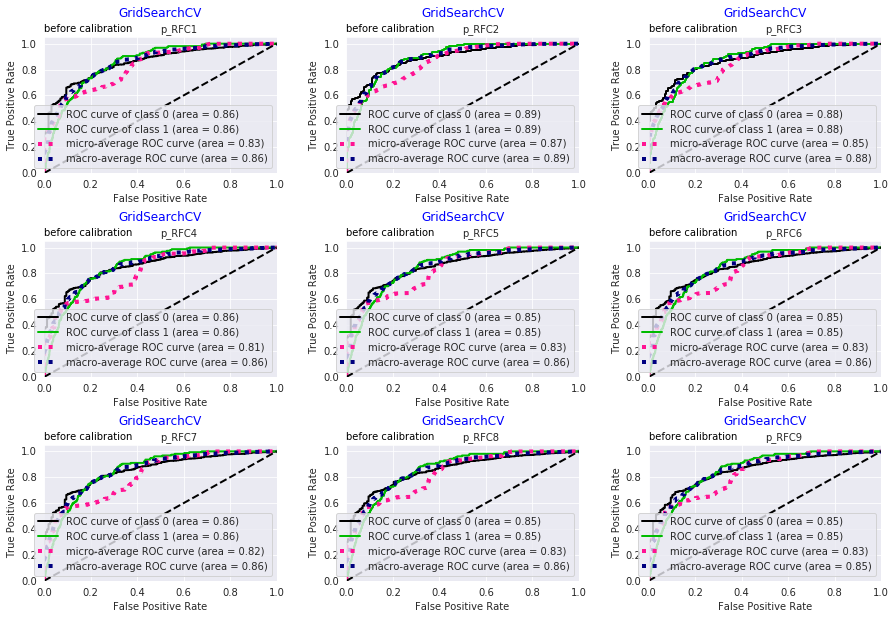

In [48]:
plot_roc(classifiers_P,nameP,Data, target,X_test,y_test,calibration=False)


time: 5.0 seconds


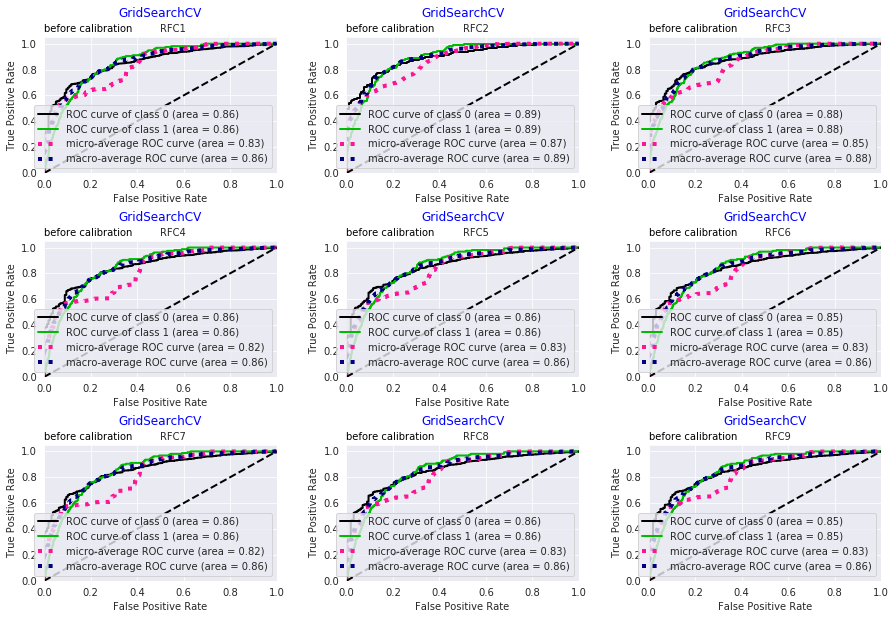

In [49]:
plot_roc(classifiers_F,nameF,X_train, y_train,X_test,y_test,calibration=False)

W tym teście szczególnie waża jest różnica pomiedzy <span style="background:#ff00ff"> krzywą micro-average ROC pokazaną na różowo</span> oraz <span style="color:#0000ff"> krzywą macro-average ROC pokazana na granatowo</span>.
Idealnie gdy obie krzywe się pokrywają. Zbilansowanie klas prze oversampling poprawiło w wielu medelach spójność obu krzywych, w niektórych jednak pozostały duże różnice.

Jeżeli: 

<span style="font-size: 150%;color:#0000ff">macro average ROC</span><span style="font-size: 250%"> > </span> <span style="font-size: 150%;background:#ff00ff">micro average ROC</span> 
wtedy mówimy, że: "1 (minority) is better classified than 0 (majority) - macro > micro"

Jeżeli:

<span style="font-size: 150%;color:#0000ff">macro average ROC</span><span style="font-size: 250%"> < </span> <span style="font-size: 150%;background:#ff00ff">micro average ROC</span> 
wtedy mówimy, że: '0 (majority) is better classified than 1 (minority)- micro < macro'


Idealnie gdy krzywe micro i macro pokrywają się ze sobą. Taka sytuacja ma miejsce po oversampling w GaussianNB oraz GradientBoostingClassifier.



## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Cohen Kappa Metric

<font size="3"> 
$ \bbox[20px,border:1px solid red]
{
 κ = \displaystyle\frac{(p_o - p_e)}{(1 - p_e)}=1-\frac{1 - p_e}{1 - p_e}
\qquad   
} $


where: 

$ p_0 = \displaystyle\frac{(tn+𝑡𝑝)}{(tn+fp+fn+𝑡𝑝)}$

$ p_{empire} = \displaystyle\frac{(tn+fp)}{(tn+fp+fn+𝑡𝑝)}\times\frac{(tn+fn)}{(tn+fp+fn+𝑡𝑝)}$

$ p_{theory} = \displaystyle\frac{(fn+𝑡𝑝)}{(tn+fp+fn+𝑡𝑝)}\times\frac{(fp+𝑡𝑝)}{(tn+fp+fn+𝑡𝑝)}$


$ p_e = p_{empire}+p_{theory}$



In [50]:
def Cohen_Kappa(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=False):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from sklearn import metrics
    import simple_colors
    import time   
    
    start_time = time.time()
    
    κ = ['κ:']
    p0 = ['p0:']
    pe = ['pe:']
    
    κc = ['κ:']
    p0c = ['p0:']
    pec = ['pe:']    
    
    
    
    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)    
    
    def compute_metric(model):
        
        from sklearn.metrics import confusion_matrix

        #model.fit(X_train,y_train)
        cm = confusion_matrix(y_test, model.predict(X_test))
        tn, fp, fn, tp = cm.ravel()     
        
        p0 = (tn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝)
        P_empire = ((tn+fp)/(tn+fp+fn+𝑡𝑝))*((tn+fn)/(tn+fp+fn+𝑡𝑝))
        P_theory = ((fn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))*((fp+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))
        pe = P_empire + P_theory
        κ = (p0-pe)/(1-pe)
        
        κ = np.round(κ,decimals=3)
        p0 = np.round(p0,decimals=3)
        pe = np.round(pe,decimals=3)
        
        return κ,p0, pe

    for cls in six_classifiers:
        
        results = compute_metric(cls)
        κ.append(blue(results[0],'bold'))
        p0.append(results[1])
        pe.append(results[2])
      

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(p0)
    t.add_row(pe)
    t.add_row(κ)

    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s second' % g)
    print(t)   
    print()
  ###------------------------------------------------------------  
    
    if calibration != True:
        print()
    else:   
        print(blue('Models after calibration','bold'))
        
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)
        
        start_time = time.time()
    
        def compute_metric2(model):
            
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)     
            
            calibrated = calibrated.fit(X_train,y_train)
            cm = confusion_matrix(y_test, calibrated.predict(X_test))
            tn, fp, fn, tp = cm.ravel()
   
        
            p0c = (tn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝)
            P_empire = ((tn+fp)/(tn+fp+fn+𝑡𝑝))*((tn+fn)/(tn+fp+fn+𝑡𝑝))
            P_theory = ((fn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))*((fp+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))
            pec = P_empire + P_theory
            κc = (p0c-pec)/(1-pec)
        
            κc = np.round(κc,decimals=3)
            p0c = np.round(p0c,decimals=3)
            pec = np.round(pec,decimals=3)
        
            return κc,p0c, pec

        for cls in six_classifiers:
        
            results = compute_metric2(cls)
            κc.append(blue(results[0],'bold'))
            p0c.append(results[1])
            pec.append(results[2])
      

        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(p0c)
        k.add_row(pec)
        k.add_row(κc)

        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s second' % n)         
        print(k)
    
    print(blue('Obserwowana zgodność p0', 'underlined'))
    print(black('Jest to prawdopodobieństwo dobrego wyboru, to procent przypadków, które zostały sklasyfikowane prawidłowo w całej matrycy zamieszania, czyli prawdziwi chorzy zostali sklasyfikowani jako chorzy a prawdziwie zdrowi sklasyfikowani jako prawdziwie zdrowi','italic'))
    print(blue('Oczekiwana zgodność pe', 'underlined'))
    print(black('Jest to prawdopodobieństwo wyboru bezpośrednio związana z liczbą wystąpień każdej klasy. Jeżeli wystąpień klas było po równo (np. 1: 20 wystąpień i 0: 20 wystapień), czyli zbiór był zbilansowany, to prawdopodobieństwo wynosi 50%. ','italic'))
    print(blue('Cohen Kappa mówi, o ile lepszy jest model klasyfikacji (p0) od losowego klasyfikatora(pe), który przewiduje na podstawie częstotliwości klas.','italic'))
    print(black(''))
    print(black('Statystyka może być ujemna, co oznacza, że nie ma skutecznej zgodności między dwoma wskaźnikami lub zgodność jest gorsza niż losowa.'))

In [51]:
Cohen_Kappa(classifiers_P,nameP,Data, target,X_test,y_test,calibration=False)

Models before calibration
time: 6.0 second
+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| Name | p_RFC1 | p_RFC2 | p_RFC3 | p_RFC4 | p_RFC5 | p_RFC6 | p_RFC7 | p_RFC8 | p_RFC9 |
+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| p0:  | 0.696  | 0.743  | 0.707  | 0.691  | 0.695  | 0.696  | 0.692  | 0.695  | 0.696  |
| pe:  | 0.677  | 0.721  | 0.686  | 0.671  | 0.675  | 0.676  | 0.672  | 0.675  | 0.676  |
|  κ:  |  0.06  | 0.079  | 0.067  |  0.06  |  0.06  | 0.061  |  0.06  | 0.061  | 0.061  |
+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+


Obserwowana zgodność p0
Jest to prawdopodobieństwo dobrego wyboru, to procent przypadków, które zostały sklasyfikowane prawidłowo w całej matrycy zamieszania, czyli prawdziwi chorzy zostali sklasyfikowani jako chorzy a prawdziwie zdrowi sklasyfikowani jako prawdziwie zdrowi
Oczekiwana zgodność pe
Jest to prawdopodobieństwo 

In [52]:
Cohen_Kappa(classifiers_F,nameF,X_train, y_train,X_test,y_test,calibration=False)

Models before calibration
time: 5.0 second
+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Name |  RFC1 |  RFC2 |  RFC3 |  RFC4 |  RFC5 |  RFC6 |  RFC7 |  RFC8 |  RFC9 |
+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| p0:  | 0.696 | 0.743 | 0.705 | 0.691 | 0.696 | 0.696 | 0.693 | 0.696 | 0.696 |
| pe:  | 0.677 | 0.721 | 0.684 | 0.671 | 0.676 | 0.677 | 0.673 | 0.676 | 0.677 |
|  κ:  |  0.06 |  0.08 | 0.066 |  0.06 | 0.061 |  0.06 |  0.06 | 0.061 | 0.061 |
+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+


Obserwowana zgodność p0
Jest to prawdopodobieństwo dobrego wyboru, to procent przypadków, które zostały sklasyfikowane prawidłowo w całej matrycy zamieszania, czyli prawdziwi chorzy zostali sklasyfikowani jako chorzy a prawdziwie zdrowi sklasyfikowani jako prawdziwie zdrowi
Oczekiwana zgodność pe
Jest to prawdopodobieństwo wyboru bezpośrednio związana z liczbą wystąpień każdej klasy. J

# <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Matthews Correlation Coefficient MCC  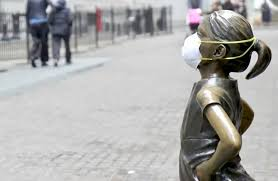

The Matthews Correlation Coefficient (MCC) has a range of -1 to 1, where -1 is a completely bad binary classifier and 1 is a completely valid binary classifier.


<font size="3"> 
$ \bbox[23px,border:1px solid red]
{
 MCC = \displaystyle\frac{{(tp \times tn)}-{(fp \times fn)}}{(tp+fp)(tp+fn)(tn+fp)(tn+fn)}
\qquad   
} $

In [53]:
def MCC(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    import time   
    
    start_time = time.time()
    
    from sklearn import metrics
    import simple_colors
    
    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)    
    
    
    MCC = ['MCC:']
    
    def compute_metric(model):
        
        from sklearn.metrics import confusion_matrix

        #model.fit(X_train,y_train)
        cm = confusion_matrix(y_test, model.predict(X_test))
        tn, fp, fn, tp = cm.ravel()     
        
        MCC = ((tp*tn)-(fp*fn))/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))** .5)
        MCC = np.round(MCC,decimals=3)
        MCC
        
        return MCC

    for cls in six_classifiers:
        
        results = compute_metric(cls)
        MCC.append(results)
             

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(MCC)
    
    print('Matthews Correlation Coefficient MCC')
        
    ### ---------------------------------------------------
    
    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
    
    ### ---------------------------------------------------
        
    if calibration != True:
        print()
    else:   
        print(blue('Models after calibration','bold'))

   

        start_time = time.time()
    
        from sklearn import metrics
        import simple_colors
    
        #for cls in six_classifiers:
        #    cls.fit(X_train, y_train)    
    
    
        MCC = ['MCC:']
    
        def compute_metric(model):
        
            from sklearn.metrics import confusion_matrix

            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)    
            cm = confusion_matrix(y_test, calibrated.predict(X_test))
            tn, fp, fn, tp = cm.ravel()     
        
            MCC = ((tp*tn)-(fp*fn))/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))** .5)
            MCC = np.round(MCC,decimals=3)
            MCC
        
            return MCC

        for cls in six_classifiers:
        
            results = compute_metric(cls)
            MCC.append(results)
             

        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(MCC)
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)         
        print(k)
    
       
    print(black('Współczynnik korelacji Matthewsa (MCC) ma zakres od -1 do 1, gdzie -1 oznacza całkowicie zły klasyfikator binarny, a 1 oznacza całkowicie poprawny klasyfikator binarny','italic'))
    

In [54]:
MCC(classifiers_P,nameP,Data, target,X_test,y_test,calibration=False)

Matthews Correlation Coefficient MCC
Models before calibration
time: 6.0 seconds
+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| Name | p_RFC1 | p_RFC2 | p_RFC3 | p_RFC4 | p_RFC5 | p_RFC6 | p_RFC7 | p_RFC8 | p_RFC9 |
+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| MCC: | 0.157  | 0.186  |  0.17  | 0.158  | 0.158  | 0.158  | 0.158  |  0.16  |  0.16  |
+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+

Współczynnik korelacji Matthewsa (MCC) ma zakres od -1 do 1, gdzie -1 oznacza całkowicie zły klasyfikator binarny, a 1 oznacza całkowicie poprawny klasyfikator binarny


In [55]:
MCC(classifiers_F,nameF,X_train, y_train,X_test,y_test,calibration=False)

Matthews Correlation Coefficient MCC
Models before calibration
time: 5.0 seconds
+------+-------+-------+-------+-------+------+-------+-------+------+-------+
| Name |  RFC1 |  RFC2 |  RFC3 |  RFC4 | RFC5 |  RFC6 |  RFC7 | RFC8 |  RFC9 |
+------+-------+-------+-------+-------+------+-------+-------+------+-------+
| MCC: | 0.157 | 0.188 | 0.169 | 0.158 | 0.16 | 0.157 | 0.157 | 0.16 | 0.158 |
+------+-------+-------+-------+-------+------+-------+-------+------+-------+

Współczynnik korelacji Matthewsa (MCC) ma zakres od -1 do 1, gdzie -1 oznacza całkowicie zły klasyfikator binarny, a 1 oznacza całkowicie poprawny klasyfikator binarny


https://en.wikipedia.org/wiki/Cohen%27s_kappa

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Trainsize

Jak widac na wykresach problemem jest precyzjia klasy 1. Nie pomogła w tym zbilansowanie zbiorów przez oversampling.

https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

### Koniec pomiaru czasu 

In [56]:
print('Time to complete the task')
print('minutes: ',
(time.time() - start_time)/60) ## koniec pomiaru czasu
t = (time.time() - start_time)/60
a,b = df.shape

print('Czas ile minut na jedne rekord: ',t/a)

Time to complete the task
minutes:  906.2214557329813
Czas ile minut na jedne rekord:  0.020880678742345758


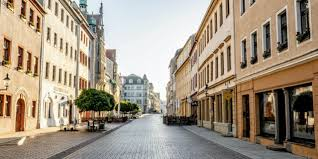